In [61]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor

from sklearn.neural_network import MLPRegressor

import IPython

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

# set up to view all the info of the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

**Input Data**
* Data stored in a csv file are stored in a dataframe

In [62]:
cars_original = pd.read_csv(r'C:\Users\margh\OneDrive\Documenti\GIT\Marketing_Analytics\car_data.csv')
cars_original.head()

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


### **Exploratory Data Analysis**
* The analysis report presents that the DataFrame has 11914 rows and each row represents one car. The DataFrame has 16 features, 8 of which are catergorical. Engine Fuel Type, Engine HP, Engine Cylinders, Number of Doors, Market Category present missing values.

In [63]:
#@ Exploratory Data Analysis:
cars_original.info()                  # Inspecting the DataFrame.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Market Category    8172 non-null   object 
 10  Vehicle Size       11914 non-null  object 
 11  Vehicle Style      11914 non-null  object 
 12  highway MPG        11914 non-null  int64  
 13  city mpg           11914 non-null  int64  
 14  Popularity         11914 non-null  int64  
 15  MSRP               11914 non-null  int64  
dtypes: float64(3), int64(5

**Market category**
* This column includes a list of elements
* it is transformed in several columns, one for each element

In [64]:
mc = cars_original['Market Category'].str.get_dummies(',')
c_0 =cars_original.drop('Market Category', axis = 1)
cars = pd.concat([c_0, mc], axis=1)

cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11911 non-null  object 
 4   Engine HP          11845 non-null  float64
 5   Engine Cylinders   11884 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11908 non-null  float64
 9   Vehicle Size       11914 non-null  object 
 10  Vehicle Style      11914 non-null  object 
 11  highway MPG        11914 non-null  int64  
 12  city mpg           11914 non-null  int64  
 13  Popularity         11914 non-null  int64  
 14  MSRP               11914 non-null  int64  
 15  Crossover          11914 non-null  int64  
 16  Diesel             119

### **Number of Doors**
* There is clearly a different definition for the number of doors, so I changed 3 to 2 for coherence

In [65]:
cars[cars['Number of Doors'] == 3]['Number of Doors']=2


### **Fill Nan**
* Engine Fuel Type: only 3 are missing, so I fill with the average value of the same make and model, which is constant
* Missing vlues for electric cars are averaged over electric cars only
* Flex fuel with gas is the average of the same mKE/MODEL/YEAR

In [66]:

fill_mode = lambda g:g.fillna(g.value_counts().idxmax()[0])
cars[['Engine Fuel Type']] = cars[['Engine Fuel Type']].groupby([cars['Make'],cars['Model']]).apply(fill_mode)

fill_mean = lambda g: g.fillna(round(g.mean()))
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Year'],cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Engine Fuel Type']]).apply(fill_mean)
cars[['Engine HP','Engine Cylinders','highway MPG','city mpg' ]] = cars[['Engine HP','Engine Cylinders','highway MPG','city mpg']].groupby([cars['Make'],cars['Model'],cars['Year']]).apply(fill_mean)
cars[['Number of Doors' ]] = cars[['Number of Doors']].groupby([cars['Make'],cars['Model'],cars['Year']]).apply(fill_mean)
cars[['Number of Doors' ]] = cars[['Number of Doors']].groupby([cars['Make'],cars['Model']]).apply(fill_mean)

cars.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11914 entries, 0 to 11913
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Make               11914 non-null  object 
 1   Model              11914 non-null  object 
 2   Year               11914 non-null  int64  
 3   Engine Fuel Type   11914 non-null  object 
 4   Engine HP          11914 non-null  float64
 5   Engine Cylinders   11914 non-null  float64
 6   Transmission Type  11914 non-null  object 
 7   Driven_Wheels      11914 non-null  object 
 8   Number of Doors    11914 non-null  float64
 9   Vehicle Size       11914 non-null  object 
 10  Vehicle Style      11914 non-null  object 
 11  highway MPG        11914 non-null  int64  
 12  city mpg           11914 non-null  int64  
 13  Popularity         11914 non-null  int64  
 14  MSRP               11914 non-null  int64  
 15  Crossover          11914 non-null  int64  
 16  Diesel             119

### **Outliers**
* I checked the outliers. The value of highway MPG>300 is a mistype so I removed it ( I could have fixed but I did not see the point)
* Very eypensive cars look consistents in terms of makes

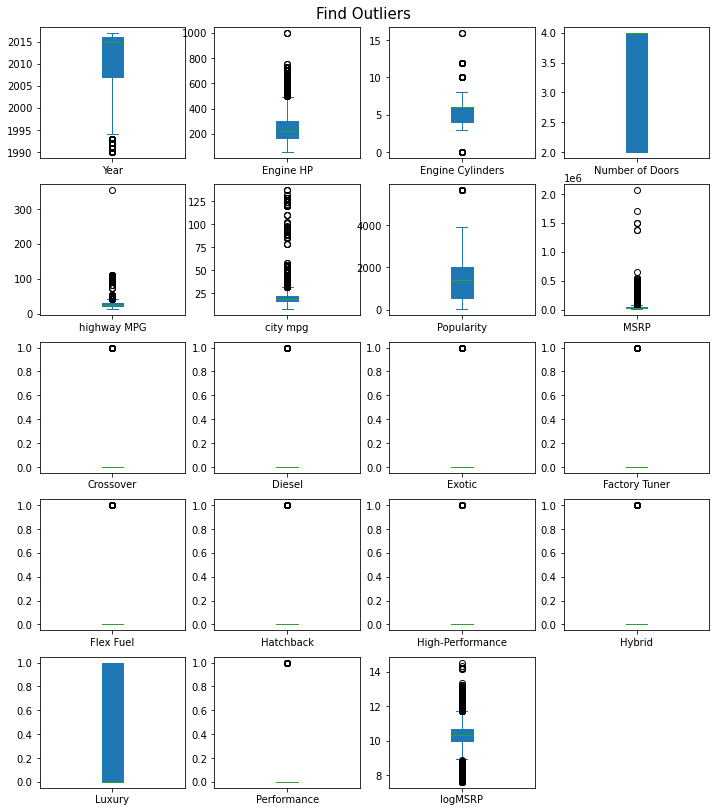

In [67]:
# See if there is any outliers

# select columns to plot

cars['logMSRP']= np.log(cars.MSRP)
# subplots
cars.plot(subplots=True, layout=(5,4), kind='box', figsize=(12,14), patch_artist=True)
plt.suptitle('Find Outliers', fontsize=15, y=0.9)
plt.savefig('boxplots.png', bbox_inches='tight')

cars = cars[cars['highway MPG']<200]

### **year**
* There is a major change at year 2000 in prices.
I will run separate analysis for the two sectors

(0.0, 30000.0)

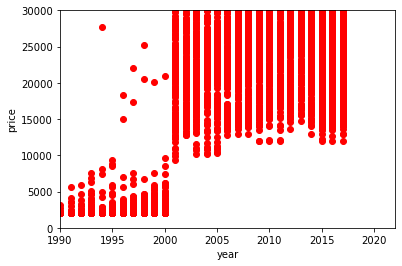

In [68]:
fig, ax = plt.subplots(1,1)


ax.scatter(cars.Year, cars.MSRP, c='red')

ax.set_xlabel('year')
ax.set_ylabel('price')
ax.set_xlim([1990, 2022])
ax.set_ylim([0, 30000])




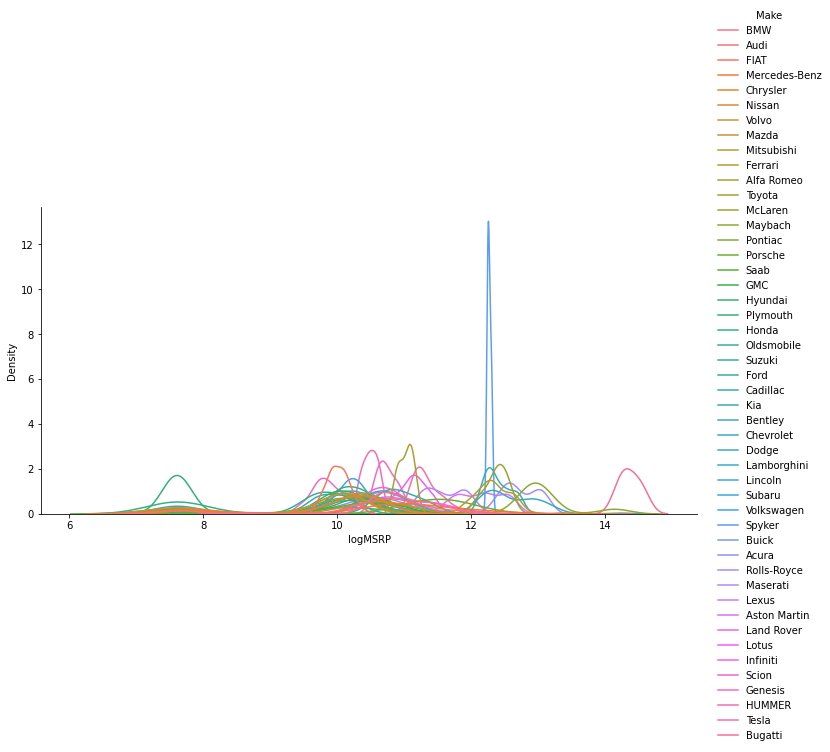

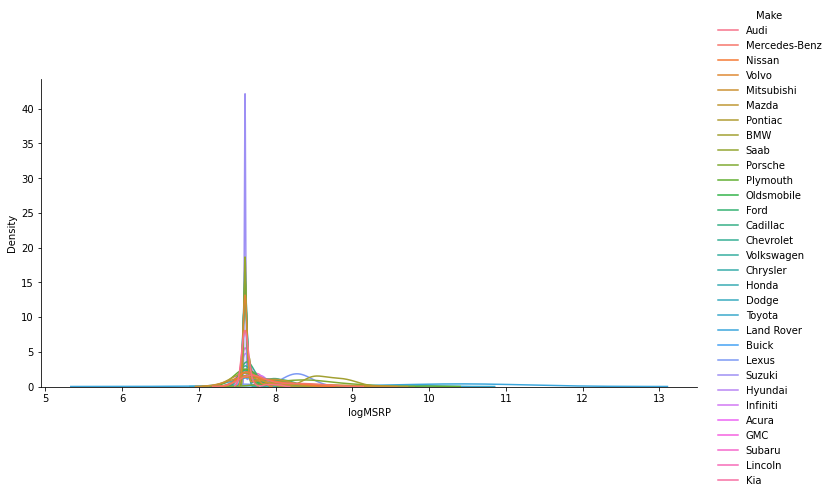

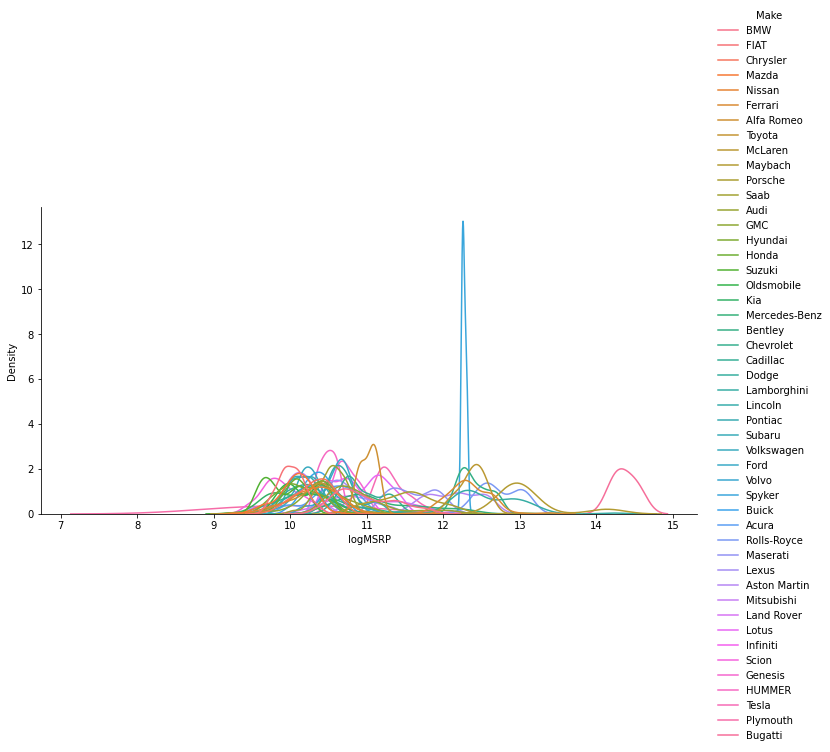

In [69]:

ax1=sns.displot(cars, x= 'logMSRP', hue ='Make',common_norm=False, kind="kde", height=5, aspect=2)
ax1=sns.displot(cars[cars.Year<2001], x= 'logMSRP', hue ='Make',common_norm=False, kind="kde", height=5, aspect=2)
ax1=sns.displot(cars[cars.Year>2000], x= 'logMSRP', hue ='Make',common_norm=False, kind="kde", height=5, aspect=2)

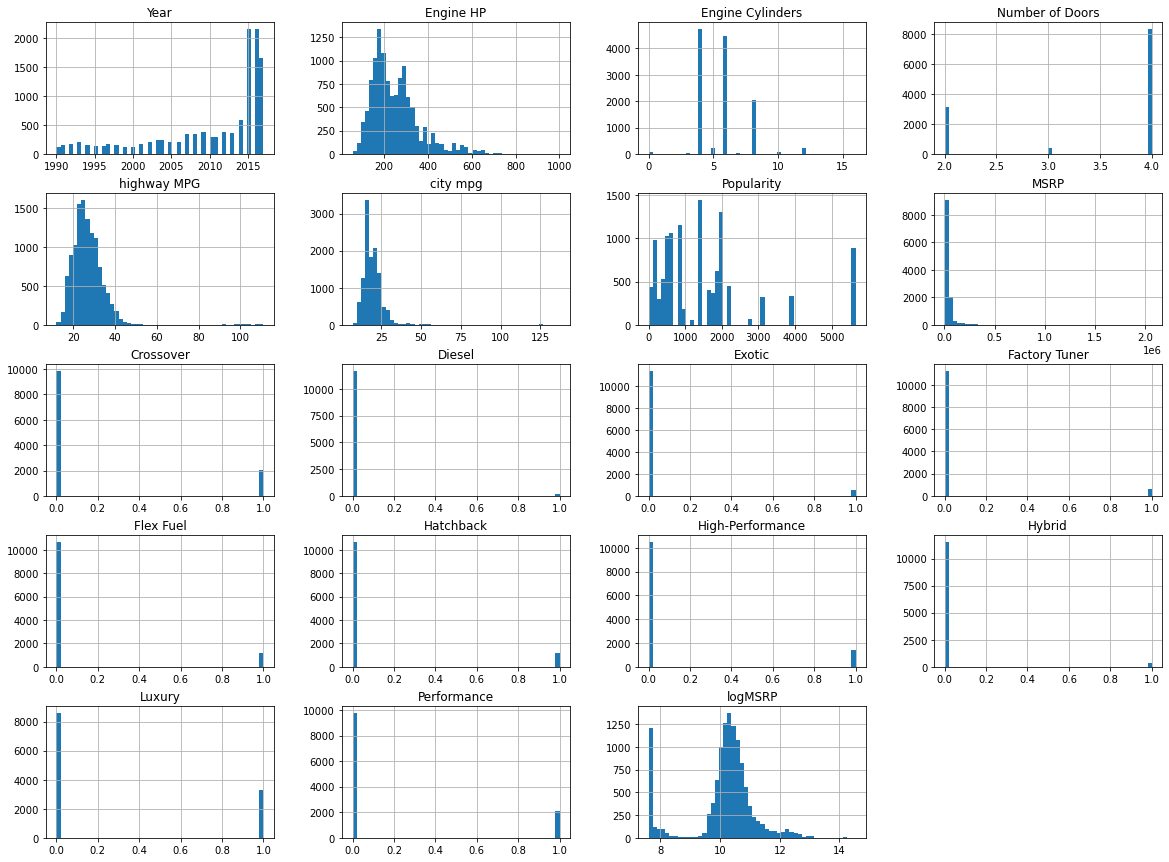

In [70]:
#@ Inspecting the Data using Histograms:
%matplotlib inline
import matplotlib.pyplot as plt
cars.hist(bins=50, figsize=(20, 15))   
plt.show()

In [71]:
makes =set(cars['Make'])
models = set(cars['Model'])


y = cars[['MSRP']]
ys = cars[['MSRP','logMSRP']]
X = cars.drop(columns=['MSRP','logMSRP'])


### **Split**
* Random split between test / val / train. We split randomly each make as we want in the training / val/test elements of each make

In [72]:
for i,make in enumerate(makes):
    X_tmp = X[cars.Make == make]
    y_tmp = ys[cars.Make == make]

    X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(X_tmp,y_tmp, test_size=0.2, random_state=1)
    X_train_tmp, X_val_tmp, y_train_tmp, y_val_tmp = train_test_split(X_train_tmp, y_train_tmp, test_size=0.25, random_state=1)
    if i==0:
        X_train = X_train_tmp
        X_test = X_test_tmp
        X_val = X_val_tmp
    else:
        X_train = pd.concat([X_train, X_train_tmp], axis=0)
        X_test = pd.concat([X_test, X_test_tmp], axis=0)
        X_val = pd.concat([X_val, X_val_tmp], axis=0)

    if i==0:
        ys_train = y_train_tmp
        ys_test = y_test_tmp
        ys_val = y_val_tmp
    else:
        ys_train = pd.concat([ys_train, y_train_tmp], axis=0)
        ys_test = pd.concat([ys_test, y_test_tmp], axis=0)
        ys_val = pd.concat([ys_val, y_val_tmp], axis=0)

### **support functions**
* prepare_data: used inside a make loop, it creates data structure with one hot encoding with only the needed options for the models
* plot_result_1: comparison on expected and predicted results for train and test

In [73]:
def prepare_data(make,X_train,X_val,X_test,y_train,y_val,y_test):
    if make == '':
        X_train_tmp =  pd.get_dummies(X_train)
        X_val_tmp =  pd.get_dummies(X_val)
        X_test_tmp =  pd.get_dummies(X_test)
        y_train_tmp = y_train
        y_val_tmp = y_val
        y_test_tmp = y_test

    else:


        X_train_tmp =  pd.get_dummies(X_train[X_train.Make == make].drop(columns=['Make']))
        X_val_tmp =  pd.get_dummies(X_val[X_val.Make == make].drop(columns=['Make']))
        X_test_tmp =  pd.get_dummies(X_test[X_test.Make == make].drop(columns=['Make']))
        y_train_tmp = y_train[X_train.Make == make]
        y_val_tmp = y_val[X_val.Make == make]
        y_test_tmp = y_test[X_test.Make == make]

    train_col=pd.get_dummies(X_train_tmp).columns
    test_col=pd.get_dummies(X_test_tmp).columns
    val_col=pd.get_dummies(X_val_tmp).columns

    cols = list(set(np.concatenate((train_col,test_col,val_col))))
    
    for col in cols:
        if (not (col in X_train_tmp.columns)):
            X_train_tmp[col] = 0
        if (not (col in X_val_tmp.columns)):
            X_val_tmp[col] = 0
        if (not (col in X_test_tmp.columns)):
            X_test_tmp[col] = 0


    X_train_tmp =  X_train_tmp[cols]
    X_val_tmp =  X_val_tmp[cols]
    X_test_tmp =  X_test_tmp[cols]
    return [ X_train_tmp,X_val_tmp,X_test_tmp,np.ravel (y_train_tmp),np.ravel (y_val_tmp),np.ravel (y_test_tmp)]

### **Metrics**
* This is my chioice. I aim to obtain the best mean_absolute_percentage_error

In [74]:
def plot_result_1(y_val, y_val_pred):

    print(' Mean Absolute percentage Error:', 
    metrics.mean_absolute_percentage_error(y_val, y_val_pred, ))


    fig, axes = plt.subplots(1,3)
    fig.set_size_inches(14, 3)
    fig.tight_layout()
    fig.subplots_adjust(left=0.1,  bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

    ax= axes[0]
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_xlabel('real value')
    ax.set_ylabel('predicted value')


    ax= axes[1]
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_title('Validation - recorded vs predicted ')
    ax.set_xlabel('real value')
    ax.set_ylabel('predicted value')
    ax.set_xlim([0, 500000])
    ax.set_ylim([0, 500000])
    


    ax= axes[2]
    ax.scatter(np.ravel (y_val), np.ravel (y_val_pred), c='red')
    ax.plot(np.ravel (y_val), np.ravel (y_val), c='blue')
    ax.set_xlabel('real value')
    ax.set_ylabel('predicted value')
    ax.set_xlim([0, 50000])
    ax.set_ylim([0, 50000])
    plt.show() 
    return

### **target**
* option to choose between value and log of value

In [83]:
ylog = False
if ylog:
    y_train = ys_train[['logMSRP']]
    y_val = ys_val[['logMSRP']]
    y_test = ys_test[['logMSRP']]
else:
    y_train = ys_train[['MSRP']]
    y_val = ys_val[['MSRP']]
    y_test = ys_test[['MSRP']]
    


### **Tuning**
* Several hyperparameter options and several algorithms are tested
* one regressor per Make is trained

 Mean Absolute percentage Error: 0.2695400761943794


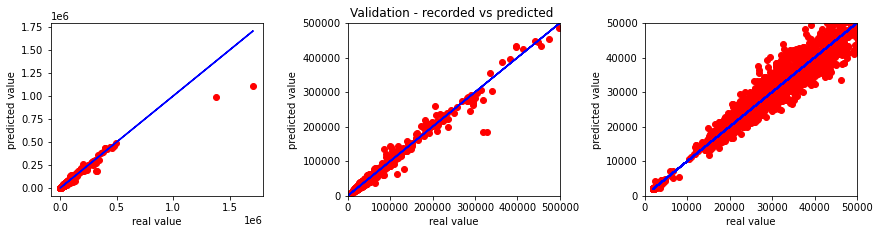

 Mean Absolute percentage Error: 0.2057668358738975


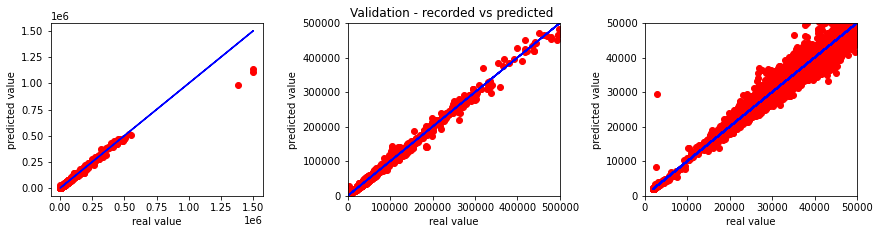

In [85]:
rg_list = []
#Create a Random Forest Classifier with 100 trees
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=10, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=20, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,criterion='absolute_error',max_depth=50, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=50, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,criterion='poisson_error',max_depth=50, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=100, n_jobs=-1))
#rg_list.append( MLPRegressor(hidden_layer_sizes=(64,64,64),activation="relu" ,random_state=1, max_iter=2000))
#rg_list.append( MLPRegressor(hidden_layer_sizes=(164,164,164),activation="relu" ,random_state=1, max_iter=2000))
#rg_list.append( MLPRegressor(hidden_layer_sizes=(64,64,64,64),activation="relu" ,random_state=1, max_iter=2000))


for j ,rg in enumerate (rg_list):
    
    [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data( make='',X_train=X_train,X_val=X_val,X_test=X_test,y_train=y_train,y_val=y_val,y_test=y_test)
    rg.fit(X_train_tmp, y_train_tmp)
    y_val_pred=rg.predict(X_val_tmp)
    y_train_pred=rg.predict(X_train_tmp)
    y_test_pred=rg.predict(X_test_tmp)

            
    plot_result_1(y_val, y_val_pred)
    plot_result_1(y_train, y_train_pred)

 Mean Absolute percentage Error: 0.2713547875539289


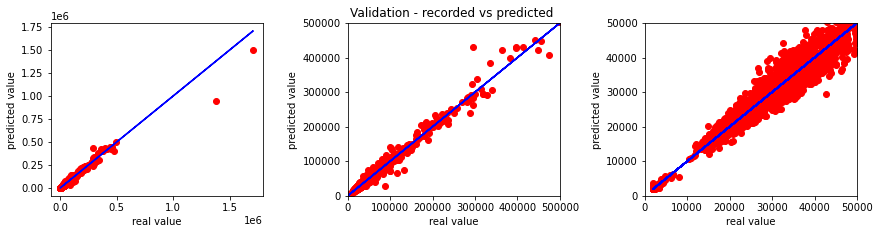

 Mean Absolute percentage Error: 0.20170995383024087


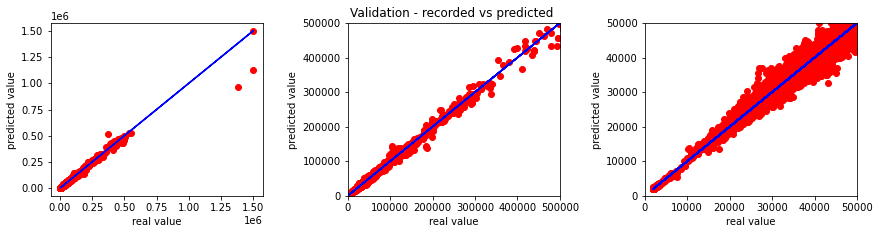

 Mean Absolute percentage Error: 0.2715525409326437


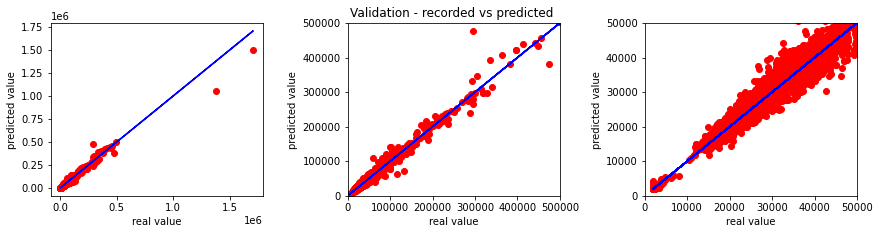

 Mean Absolute percentage Error: 0.20160923705884282


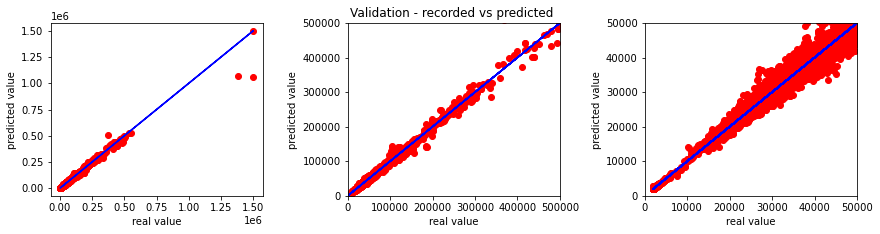

 Mean Absolute percentage Error: 0.2723161364596172


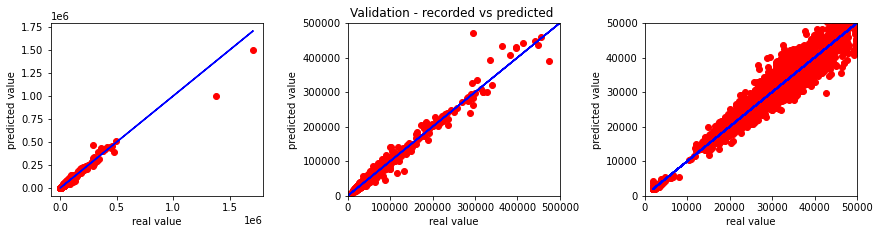

 Mean Absolute percentage Error: 0.20157090867527705


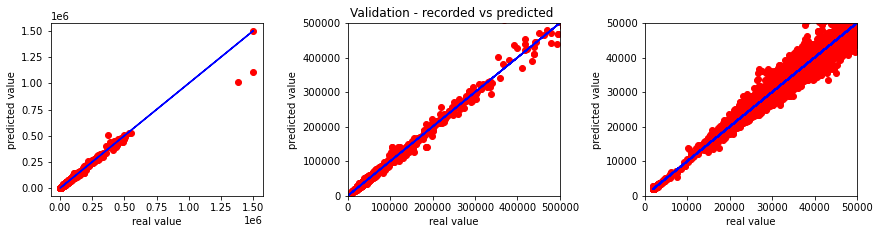

In [79]:
rg_list = []
#Create a Random Forest Classifier with 100 trees
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=10, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=20, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,criterion='absolute_error',max_depth=50, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='squared_error',max_depth=50, n_jobs=-1))
rg_list.append( RandomForestRegressor(n_estimators=200,criterion='poisson',max_depth=50, n_jobs=-1))
#rg_list.append( RandomForestRegressor(n_estimators=200,max_depth=100, n_jobs=-1))
#rg_list.append( MLPRegressor(hidden_layer_sizes=(64,64,64),activation="relu" ,random_state=1, max_iter=2000))
#rg_list.append( MLPRegressor(hidden_layer_sizes=(164,164,164),activation="relu" ,random_state=1, max_iter=2000))
#rg_list.append( MLPRegressor(hidden_layer_sizes=(64,64,64,64),activation="relu" ,random_state=1, max_iter=2000))

year=2000
for j ,rg in enumerate (rg_list):
        
    y_test_pred = pd.Series([])    
    y_val_pred = pd.Series([])         
    y_train_pred = pd.Series([])  
        
    y_test_obs = pd.Series([])    
    y_val_obs = pd.Series([])         
    y_train_obs = pd.Series([])  
        
    for i,make in enumerate(makes):

        [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data(  make=make,
        X_train=X_train[X_train.Year<=year],X_val=X_val[X_val.Year<=year],X_test=X_test[X_test.Year<=year],
        y_train=y_train[X_train.Year<=year],y_val=y_val[X_val.Year<=year],y_test=y_test[X_test.Year<=year])
        if (X_train_tmp.shape[0]>0 and X_val_tmp.shape[0]>0 and X_test_tmp.shape[0]>0):
            rg.fit(X_train_tmp, y_train_tmp)
            y_val_pred_tmp=rg.predict(X_val_tmp)
            y_train_pred_tmp=rg.predict(X_train_tmp)
            y_test_pred_tmp=rg.predict(X_test_tmp)

            y_test_pred = np.concatenate((y_test_pred, y_test_pred_tmp))
            y_val_pred = np.concatenate((y_val_pred, y_val_pred_tmp))
            y_train_pred = np.concatenate((y_train_pred, y_train_pred_tmp))
            y_test_obs = np.concatenate((y_test_obs, y_test_tmp))
            y_val_obs = np.concatenate((y_val_obs, y_val_tmp))
            y_train_obs = np.concatenate((y_train_obs, y_train_tmp))

        [ X_train_tmp,X_val_tmp,X_test_tmp,y_train_tmp,y_val_tmp,y_test_tmp] = prepare_data(  make=make,
        X_train=X_train[X_train.Year>year],X_val=X_val[X_val.Year>year],X_test=X_test[X_test.Year>year],
        y_train=y_train[X_train.Year>year],y_val=y_val[X_val.Year>year],y_test=y_test[X_test.Year>year])
        if (X_train_tmp.shape[0]>0 and X_val_tmp.shape[0]>0 and X_test_tmp.shape[0]>0):
            rg.fit(X_train_tmp, y_train_tmp)
            y_val_pred_tmp=rg.predict(X_val_tmp)
            y_train_pred_tmp=rg.predict(X_train_tmp)
            y_test_pred_tmp=rg.predict(X_test_tmp)

            y_test_pred = np.concatenate((y_test_pred, y_test_pred_tmp))
            y_val_pred = np.concatenate((y_val_pred, y_val_pred_tmp))
            y_train_pred = np.concatenate((y_train_pred, y_train_pred_tmp))
            y_test_obs = np.concatenate((y_test_obs, y_test_tmp))
            y_val_obs = np.concatenate((y_val_obs, y_val_tmp))
            y_train_obs = np.concatenate((y_train_obs, y_train_tmp))
                
    plot_result_1(y_val_obs, y_val_pred)
    plot_result_1(y_train_obs, y_train_pred)


In [80]:
X_val['Predicted'] = y_val_pred
X_val['Recorded'] = y_val
X_val['Error'] = np.abs((np.ravel (y_val)- np.ravel (y_val_pred))/(np.ravel (y_val)+ 1))
X_val['absError'] = np.abs((np.ravel (y_val)- np.ravel (y_val_pred)))

X_train['Predicted'] = y_train_pred
X_train['Recorded'] = y_train
X_train['Error'] = np.abs((np.ravel (y_train)- np.ravel (y_train_pred))/(np.ravel (y_train)+ 1))
X_train['absError'] = np.abs((np.ravel (y_train)- np.ravel (y_train_pred)))

ValueError: Length of values (7110) does not match length of index (7116)

In [ ]:
X_val[X_val['Error']>0.9].sort_values(by=['Error'], ascending=False)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Crossover,Diesel,Exotic,Factory Tuner,Flex Fuel,Hatchback,High-Performance,Hybrid,Luxury,Performance,Predicted,Recorded,Error,absError
2129,Volkswagen,Cabrio,2000,regular unleaded,115.0,4.0,MANUAL,front wheel drive,2.0,Compact,Convertible,28,21,873,0,0,0,0,0,0,0,0,0,0,8776.665000,2568,2.416763,6208.665000
9108,Kia,Sephia,2000,regular unleaded,125.0,4.0,MANUAL,front wheel drive,4.0,Compact,Sedan,26,20,1720,0,0,0,0,0,0,0,0,0,0,6653.150000,2000,2.325412,4653.150000
1369,Cadillac,Allante,1993,regular unleaded,295.0,8.0,AUTOMATIC,front wheel drive,2.0,Compact,Convertible,20,13,1624,0,0,0,0,0,0,0,0,1,1,5940.128889,2358,1.518495,3582.128889
11883,BMW,Z3,2000,regular unleaded,170.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,25,17,3916,0,0,0,0,0,0,0,0,1,1,11520.985000,4755,1.422621,6765.985000
3880,Cadillac,Eldorado,2000,regular unleaded,275.0,8.0,AUTOMATIC,front wheel drive,2.0,Large,Coupe,25,15,1624,0,0,0,0,0,0,0,0,1,0,6588.125000,2905,1.267421,3683.125000
4751,Cadillac,Fleetwood,1995,regular unleaded,260.0,8.0,AUTOMATIC,rear wheel drive,4.0,Large,Sedan,23,15,1624,0,0,0,0,0,0,0,0,1,0,4515.915833,2000,1.257329,2515.915833
4220,Suzuki,Esteem,2000,regular unleaded,122.0,4.0,MANUAL,front wheel drive,4.0,Compact,Sedan,32,24,481,0,0,0,0,0,0,0,0,0,0,4317.530000,2000,1.158186,2317.530000
5122,Infiniti,G20,2000,regular unleaded,145.0,4.0,MANUAL,front wheel drive,4.0,Compact,Sedan,29,21,190,0,0,0,0,0,0,0,0,1,0,4354.911500,2251,0.934241,2103.911500


In [ ]:
X_train[X_train['Error']>0.9].sort_values(by=['Error'], ascending=False)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Crossover,Diesel,Exotic,Factory Tuner,Flex Fuel,Hatchback,High-Performance,Hybrid,Luxury,Performance,Predicted,Recorded,Error,absError
3575,Land Rover,Discovery Series II,2000,regular unleaded,188.0,8.0,AUTOMATIC,all wheel drive,4.0,Midsize,4dr SUV,16,12,258,0,0,0,0,0,0,0,0,1,0,13791.561667,2561,4.383514,11230.561667
760,BMW,8 Series,1995,regular unleaded,322.0,12.0,AUTOMATIC,rear wheel drive,2.0,Midsize,Coupe,19,12,3916,0,0,0,0,0,0,0,0,1,1,21584.220000,5858,2.684113,15726.220000
2128,Volkswagen,Cabrio,2000,regular unleaded,115.0,4.0,MANUAL,front wheel drive,2.0,Compact,Convertible,28,21,873,0,0,0,0,0,0,0,0,0,0,8776.665000,2473,2.547965,6303.665000
9106,Kia,Sephia,1999,regular unleaded,125.0,4.0,MANUAL,front wheel drive,4.0,Compact,Sedan,28,21,1720,0,0,0,0,0,0,0,0,0,0,6653.150000,2000,2.325412,4653.150000
978,Porsche,928,1993,regular unleaded,345.0,8.0,MANUAL,rear wheel drive,2.0,Compact,2dr Hatchback,17,11,1715,0,0,0,0,0,1,0,0,1,1,13580.585000,6294,1.157519,7286.585000
4223,Suzuki,Esteem,2000,regular unleaded,122.0,4.0,MANUAL,front wheel drive,4.0,Compact,Wagon,31,24,481,0,0,0,0,0,0,0,0,0,0,4253.655000,2000,1.126264,2253.655000
3881,Cadillac,Eldorado,2000,regular unleaded,300.0,8.0,AUTOMATIC,front wheel drive,2.0,Large,Coupe,25,15,1624,0,0,0,0,0,0,0,0,1,0,6881.680000,3257,1.112548,3624.680000
4752,Cadillac,Fleetwood,1996,regular unleaded,260.0,8.0,AUTOMATIC,rear wheel drive,4.0,Large,Sedan,24,15,1624,0,0,0,0,0,0,0,0,1,0,4520.347976,2158,1.094186,2362.347976
759,BMW,8 Series,1995,regular unleaded,282.0,8.0,AUTOMATIC,rear wheel drive,2.0,Midsize,Coupe,22,15,3916,0,0,0,0,0,0,0,0,1,1,10014.460000,4784,1.093095,5230.460000
4691,Pontiac,Firebird,2000,regular unleaded,305.0,8.0,UNKNOWN,rear wheel drive,2.0,Midsize,2dr Hatchback,23,15,210,0,0,0,0,0,1,0,0,0,1,12899.746429,6175,1.088851,6724.746429


In [ ]:
X_val[X_val['absError']>100000].sort_values(by=['absError'], ascending=False)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Crossover,Diesel,Exotic,Factory Tuner,Flex Fuel,Hatchback,High-Performance,Hybrid,Luxury,Performance,Predicted,Recorded,Error,absError
11364,Bugatti,Veyron 16.4,2009,premium unleaded (required),1001.0,16.0,AUTOMATED_MANUAL,all wheel drive,2.0,Compact,Coupe,14,8,820,0,0,1,0,0,0,1,0,0,0,2065902.0,1705769,0.211126,360133.0


In [ ]:
ind = [i  for i in range(len(y_val)) if np.abs((np.ravel (y_val)[i]- np.ravel (y_val_pred)[i])/(np.ravel (y_val)[i]+ 1))>0.5 ]
very_wrong = X_val.iloc[ind,:]
very_wrong.head()
#(np.ravel (y_val)[1]- np.ravel (y_val_pred)[1])/(np.ravel (y_val)[1]+ 1)>0.1

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,Crossover,Diesel,Exotic,Factory Tuner,Flex Fuel,Hatchback,High-Performance,Hybrid,Luxury,Performance,Predicted,Recorded,Error,absError
11883,BMW,Z3,2000,regular unleaded,170.0,6.0,MANUAL,rear wheel drive,2.0,Compact,Convertible,25,17,3916,0,0,0,0,0,0,0,0,1,1,11520.985000,4755,1.422621,6765.985000
763,BMW,8 Series,1996,regular unleaded,282.0,8.0,AUTOMATIC,rear wheel drive,2.0,Midsize,Coupe,19,14,3916,0,0,0,0,0,0,0,0,1,1,10733.250000,5680,0.889500,5053.250000
7188,Plymouth,Neon,2001,regular unleaded,132.0,4.0,MANUAL,front wheel drive,4.0,Compact,Sedan,30,24,535,0,0,0,0,0,0,0,0,0,0,4151.594667,12715,0.673435,8563.405333
259,Mercedes-Benz,350-Class,1991,diesel,134.0,6.0,AUTOMATIC,rear wheel drive,4.0,Large,Sedan,23,19,617,0,1,0,0,0,0,0,0,1,0,3993.380000,2311,0.727673,1682.380000
256,Mercedes-Benz,350-Class,1990,diesel,134.0,6.0,AUTOMATIC,rear wheel drive,4.0,Large,Sedan,23,19,617,0,1,0,0,0,0,0,0,1,0,4010.270000,2144,0.870056,1866.270000
